In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import h5py
from astropy.io import fits
from astropy.convolution import Gaussian1DKernel, convolve
from scipy import interpolate
import pickle
import random
from scipy.interpolate import interp1d

In [2]:
source_name = 'ATCA'

In [3]:
# Directory path where your files are located
directory_path = '../data/ATCA_HI_spectra/Norma'

# Common part of the filename
common_part_v4 = '_cube_4k_atca_4k_spectrum.txt'
# Common part of the filename
common_part_v2 = '_cube_v2_atca_spectrum.txt'

# List all files in the directory
all_files = os.listdir(directory_path)

# Filter files based on the common part of the filename
files_spectra_v4 = [file for file in all_files if common_part_v4 in file]

# Filter files based on the common part of the filename
files_spectra_v2 = [file for file in all_files if common_part_v2 in file]

### Test

In [ ]:
#data = np.loadtxt('ATCA_HI_spectra/Hydra/j103913-2509_cube_4k_atca_4k_spectrum.txt', skiprows=1)
# Select one random file name from each list if they are not empty
random_file_v4 = random.choice(files_spectra_v4) if files_spectra_v4 else None
random_file_v2 = random.choice(files_spectra_v2) if files_spectra_v2 else None    

data = np.loadtxt(f'../ATCA_HI_spectra/Norma/{random_file_v4}', skiprows = 1)

In [ ]:
velocity = data[:, 1]
amplitude = data[:, 2]

#Measue variability
rms_spect = np.sqrt(np.mean(amplitude**2))

#Mask signal channels
spectrum = np.copy(amplitude)
spectrum[spectrum < rms_spect - (np.max(spectrum)-rms_spect) ] = rms_spect

#Normalization
y = spectrum
x = velocity
pars = np.polyfit(x, y, 1)
p = np.poly1d(pars)
tauhi = np.array(amplitude/p(x))

# Tau
tau = np.log(tauhi)*(-1)
rms = np.std(tau)
#Smoothing
g = Gaussian1DKernel(1)
tau_smooth = convolve(tau, g, boundary='extend')
rms_smooth = np.std(tau_smooth)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})
ax1.plot(x, tau, linestyle=':', linewidth=1, color='b', label='Signal')
ax1.plot(x, tau_smooth, linestyle='-', linewidth=1, color='r', label='Smoothed')


#ax1.axhspan(-rms, + rms*3, alpha=0.2, color='orange')
ax1.axhspan(-rms_smooth, + rms_smooth, alpha=0.2, color='g')
ax1.axhline(0, color='k', linestyle='--', linewidth=2)
ax1.axhline( rms_smooth*2.5, color='r', linestyle='--', linewidth=1)
ax1.axhline( np.std(tau)*2.5, color='b', linestyle='--', linewidth=1)
#ax1.set_xlabel('v[Km/s]', fontsize=15)
ax1.set_ylabel(r'${\tau}$', fontsize=15)
ax1.grid(True)

# Add legend
ax1.legend()

ax2.plot(x, tauhi, color = 'g')
ax2.axhspan(1-np.std(tauhi), 1+ np.std(tauhi), alpha=0.2, color='grey')
ax2.axhline(1, color='k', linestyle='--', linewidth=2)
# Label the points where tauhi < 1 - 3 * std_tauhi with dots
median_tauhi = np.median(tauhi)
mad_tauhi = np.median(np.abs(tauhi - median_tauhi))
below_threshold = tauhi < (1 - 3.5 * mad_tauhi)
ax2.plot(x[below_threshold], tauhi[below_threshold], 'ro')  # Red dots
ax2.set_xlabel('v[Km/s]', fontsize=15)
ax2.set_ylabel(r'$e^{-\tau}$')

plt.show()


### Ploting

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

def plot_spectra(files_spectra, gkernel, image_name=None, source=None):
    # Calculate the number of rows and columns for subplots
    num_files = len(files_spectra)
    num_rows = int(np.ceil(num_files / 3))  # 3 subplots per row

    # Create a single figure with multiple subplots
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 8*num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Iterate through matching files and create subplots for each file
    for i, file_name in enumerate(files_spectra):
        # Construct the full file path
        file_path = os.path.join(directory_path, file_name)

        # Read data from the text file into a NumPy array, skipping the header row
        data = np.loadtxt(file_path, skiprows=1)

        # Extract velocity and amplitude columns
        velocity = data[:, 1]
        amplitude = data[:, 2]
        
        # Measure variability
        rms_spect = np.sqrt(np.mean(amplitude**2))
        
        # Mask signal channels
        spectrum = np.copy(amplitude)
        spectrum[spectrum < rms_spect - (np.max(spectrum) - rms_spect)] = rms_spect
        
        # Normalization
        y = spectrum
        x = velocity
        pars = np.polyfit(x, y, 1)
        p = np.poly1d(pars)
        tauhi = np.array(amplitude / p(x))
        
        # Tau
        tau = np.log(tauhi) * (-1)
        rms = np.std(tau)
        
        # Smoothing
        if gkernel > 0:
            g = Gaussian1DKernel(gkernel)
            tau_smooth = convolve(tau, g, boundary='extend')
            rms_smooth = np.std(tau_smooth)
        else:
            tau_smooth = tau
            rms_smooth = np.std(tau)
        # Create a nested grid within each subplot
        outer_ax = axes[i]
        gs = outer_ax.get_gridspec()
        outer_ax.remove()

        inner_gs = gs[i].subgridspec(2, 1, height_ratios=[3, 1])
        ax1 = fig.add_subplot(inner_gs[0])
        ax2 = fig.add_subplot(inner_gs[1])

        # Plotting the first panel
        ax1.plot(x, tau, linestyle=':', linewidth=1, color='b', alpha = 0.4, label='Signal')
        if gkernel > 0 :
            ax1.plot(x, tau_smooth, linestyle='-', linewidth=1, color='r', label='Smoothed')
        ax1.axhspan(-rms_smooth, rms_smooth, alpha=0.2, color='g')
        ax1.axhline(rms_smooth * 3, color='k', linestyle='--', linewidth=1)
        ax1.axhline(0, color='k', linestyle='--', linewidth=2)
        ax1.set_ylabel(r'${\tau}$', fontsize=15)
        ax1.grid(True)
        ax1.legend()
        ax1.set_title(f'File: {file_name}')

        # Plotting the second panel
        ax2.plot(x, tauhi, color='g')
        ax2.axhspan(1 - np.std(tauhi), 1 + np.std(tauhi), alpha=0.2, color='grey')
        ax2.axhline(1, color='k', linestyle='--', linewidth=2)
        ax2.set_xlabel('v[Km/s]', fontsize=15)
        ax2.set_ylabel(r'$e^{-\tau}$')

        # Title for the overall plot area
        #outer_ax.set_title(f'File: {file_name}')

    # Hide any remaining empty subplots, if any
    for j in range(num_files, num_rows * 3):
        fig.delaxes(axes[j])

    # Adjust layout and display the figure
    plt.tight_layout()
    if image_name is not None:
        # Ensure the output directory exists
        output_dir = os.path.join('../images', source)  # Change Norma or Hydra
        os.makedirs(output_dir, exist_ok=True)

        # Save the figure
        output_path = os.path.join(output_dir, f'{image_name}.pdf')
        plt.savefig(output_path, format='pdf')

    plt.show()


In [ ]:
#plot_spectra(files_spectra_v4, 1)
plot_spectra(files_spectra_v4,0,'spectra_4k_norma_raw',source_name)

In [ ]:
plot_spectra(files_spectra_v2,1, 'spectra_v2_norma_G1',source_name)

## Arrays

### 4 km/s resolution

In [4]:
gkernel = 0
crval3_4k_list = []
spect_4k_list = []
files_name_4k = []
for i, file_name in enumerate(files_spectra_v4):
    # Construct the full file path
    file_path = os.path.join(directory_path, file_name)
    
    # Read data from the text file into a NumPy array, skipping the header row
    data = np.loadtxt(file_path, skiprows=1)

    # Extract velocity and amplitude columns
    velocity = data[:, 1]
    amplitude = data[:, 2]
    
    #Measue variability
    rms_spect = np.sqrt(np.mean(amplitude**2))
    
    #Mask signal channels
    spectrum = np.copy(amplitude)
    spectrum[spectrum < rms_spect - (np.max(spectrum)-rms_spect) ] = rms_spect
    
    #Normalization
    y = spectrum
    x = velocity
    pars = np.polyfit(x, y, 1)
    p = np.poly1d(pars)
    tauhi = np.array(amplitude/p(x))
    
    # Tau
    tau = np.log(tauhi)*(-1)
    # Check for NaNs in tau and interpolate missing values
    if np.isnan(tau).any():
        # Get indices of valid and invalid (NaN) values
        valid_idx = np.where(~np.isnan(tau))[0]
        invalid_idx = np.where(np.isnan(tau))[0]
        
        # Interpolate only over the valid points
        interpolator = interp1d(x[valid_idx], tau[valid_idx], kind='linear', fill_value='extrapolate')
        
        # Apply interpolation to the NaN values
        tau[invalid_idx] = interpolator(x[invalid_idx])
        
    rms = np.std(tau)
    crval3_4k_list.append(velocity[0])
    #Smoothing
    if gkernel > 0:
        g = Gaussian1DKernel(gkernel)
        tau_smooth = convolve(tau, g, boundary='extend')
        spect_4k_list.append(tau_smooth)
    else:
        spect_4k_list.append(tau)
    files_name_4k.append(file_name.split('_cube')[0])
    

/tmp/ipykernel_2307/4150673767.py:31: RuntimeWarning: invalid value encountered in log
  tau = np.log(tauhi)*(-1)


In [5]:
len(files_name_4k)

41

In [6]:
spect_4k = np.zeros((140, 7, 6))     #Resolution of 4 km/s 
files_4k = {}

In [7]:
for i, data in enumerate(spect_4k_list):
    index1 = i // 6  # Row index
    index2 = i % 6  # Column index
    spect_4k[:, index1, index2] = data
    
    # Store source's name and position in the dict
    files_4k[files_name_4k[i]] = {"pos":(index2, index1),  "vel": crval3_4k_list[i]}

### 0.2 km/s resolution

In [8]:
gkernel = 1

spect_v2_1000 = []
spect_v2_1500 = []

files_name_v2_1000 = []
files_name_v2_1500 = []

crval3_v2_1000list = []
crval3_v2_1500list = []

for i, file_name in enumerate(files_spectra_v2):

    # Construct the full file path
    file_path = os.path.join(directory_path, file_name)
    
    # Read data from the text file into a NumPy array, skipping the header row
    data = np.loadtxt(file_path, skiprows=1)
    
    # Extract velocity and amplitude columns
    velocity = data[:, 1]
    amplitude = data[:, 2]
    
    #Measue variability
    rms_spect = np.sqrt(np.mean(amplitude**2))
    
    #Mask signal channels
    spectrum = np.copy(amplitude)
    spectrum[spectrum < rms_spect - (np.max(spectrum)-rms_spect) ] = rms_spect
    
    #Normalization
    y = spectrum
    x = velocity
    pars = np.polyfit(x, y, 1)
    p = np.poly1d(pars)
    tauhi = np.array(amplitude/p(x))
    
    # Tau
    tau = np.log(tauhi)*(-1)
        # Check for NaNs in tau and interpolate missing values
    if np.isnan(tau).any():
        # Get indices of valid and invalid (NaN) values
        valid_idx = np.where(~np.isnan(tau))[0]
        invalid_idx = np.where(np.isnan(tau))[0]
        
        # Interpolate only over the valid points
        interpolator = interp1d(x[valid_idx], tau[valid_idx], kind='linear', fill_value='extrapolate')
        
        # Apply interpolation to the NaN values
        tau[invalid_idx] = interpolator(x[invalid_idx])
        
    rms = np.std(tau)
    #Smoothing
    g = Gaussian1DKernel(gkernel)
    tau_smooth = convolve(tau, g, boundary='extend')
    
    if len(tau_smooth) != 1500:
        spect_v2_1000.append(tau_smooth)
        files_name_v2_1000.append(file_name.split('_cube')[0])
        crval3_v2_1000list.append(velocity[0])
    else:    
        spect_v2_1500.append(tau_smooth)
        files_name_v2_1500.append(file_name.split('_cube')[0])
        crval3_v2_1500list.append(velocity[0])
        


/tmp/ipykernel_2307/3900388997.py:39: RuntimeWarning: invalid value encountered in log
  tau = np.log(tauhi)*(-1)


In [9]:
print(len(spect_v2_1000))
print(len(spect_v2_1500))

9
18


In [10]:
array_1500 = np.zeros((len(spect_v2_1500[0]),6, 3))
array_1000 = np.zeros((len(spect_v2_1000[0]), 3, 3))


files_v2_1500 ={}
files_v2_1000 ={}

# Fill the NumPy arrays with data from the lists
for i, data in enumerate(spect_v2_1500):
    index1 = i // 3  # Row index
    index2 = i % 3   # Column index
    array_1500[:, index1, index2] = data
    
    # Store source's name and position in the dict
    files_v2_1500[files_name_v2_1500[i]] = {"pos":(index2, index1), "vel": crval3_v2_1500list[i]}

for i, data in enumerate(spect_v2_1000):
    index1 = i // 3  # Row index
    index2 = i % 3   # Column index
    array_1000[:, index1, index2] = data

    # Store source's name and position in the dict
    files_v2_1000[files_name_v2_1000[i]] = {"pos":(index2, index1), "vel": crval3_v2_1000list[i]}

### Creation of FITS file

In [11]:
print("ATCA cube 1 for 0.2km: ", array_1500.shape)
print("ATCA cube 2 for 0.2km: ", array_1000.shape)
print("ATCA cube for 4km: ",spect_4k.shape)

ATCA cube 1 for 0.2km:  (1500, 6, 3)
ATCA cube 2 for 0.2km:  (1000, 3, 3)
ATCA cube for 4km:  (140, 7, 6)


In [13]:
def fits_cube(data_cube, CDELT3, CRVAL3, name, source):
    # Create a new FITS HDU object from the NumPy 
    hdu = fits.PrimaryHDU(data_cube)

    hdu.header['NAXIS'] = 3
    hdu.header['NAXIS1'] = data_cube.shape[1]
    hdu.header['NAXIS2'] = data_cube.shape[2]
    hdu.header['NAXIS3'] = data_cube.shape[0]


    hdu.header['CRPIX1'] = 1.0e+00
    hdu.header['CDELT1'] = 1.0e+00
    hdu.header['CRVAL1'] = 1.0e+00
    hdu.header['CTYPE1']  = 'RA---NCP'
    hdu.header['CUNIT1'] = 'deg'

    hdu.header['CRPIX2'] = 1.0e+00
    hdu.header['CDELT2'] = 1.0e+00
    hdu.header['CRVAL2'] = 1.0e+00
    hdu.header['CTYPE2']  = 'DEC--NCP'
    hdu.header['CUNIT2'] = 'deg'


    hdu.header['CRPIX3']  = 1.0e+00
    hdu.header['CDELT3'] = CDELT3      #km/s
    hdu.header['CTYPE3']  = 'VELO-LSR'
    hdu.header['CRVAL3'] = CRVAL3      #km/s
    hdu.header['CUNIT3'] = 'km/s' 
    
    hdu.header['DATAMIN'] =  np.nanmin(data_cube)                        
    hdu.header['DATAMAX'] =  np.nanmax(data_cube)   
    
    hdu.header['SPECSYS'] = 'LSRK' 
    hdu.header['BUNIT'] = 'JY/BEAM '                                                                                                                                                                                                                                                                                                          


    # Save the FITS file
    hdu.writeto(f'../data_cubes/{source}/norma/{name}.fits', overwrite=True)


In [14]:
fits_cube(array_1500, 0.206106359695 , -146.511379438, 'spectra_norma_v2-1500_g1',source_name)
fits_cube(array_1000, 0.206106359695 , -119.41941255399999, 'spectra_norma_v2-1000_g1',source_name)
fits_cube(spect_4k, 3.91596771184 , -189.33749766100001, 'spectra_norma_4k_raw',source_name)

### Save Dictionaries 

In [16]:

with open('../data_cubes/ATCA/norma/coordiantes_norma_4k.pkl', 'wb') as f:
    pickle.dump(files_4k, f)

with open('../data_cubes/ATCA/norma/coordiantes_norma_v2_1500.pkl', 'wb') as f:
    pickle.dump(files_v2_1500, f)

with open('../data_cubes/ATCA/norma/coordiantes_norma_v2_1000.pkl', 'wb') as f:
    pickle.dump(files_v2_1000, f)

## Checking

In [17]:
from spectral_cube import SpectralCube

# Path to the FITS file
file_path1 = f'../data_cubes/{source_name}/norma/spectra_norma_v2-1500_g1.fits'
file_path2 = f'../data_cubes/{source_name}/norma/spectra_norma_4k_raw.fits'


cube1 = SpectralCube.read(file_path1)
cube2 = SpectralCube.read(file_path2)
# Open the FITS file
with fits.open(file_path1) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Access the primary HDU (Header/Data Unit)
    primary_hdu1 = hdul[0]
    
    # Print the header of the primary HDU
    print(primary_hdu1.header)
    
    # Access the data in the primary HDU
    data1 = primary_hdu1.data

# Display some basic information about the data
print(f'Data shape: {data1.shape}')
print(f'Data type: {data1.dtype}')

# Open the FITS file
with fits.open(file_path2) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Access the primary HDU (Header/Data Unit)
    primary_hdu2 = hdul[0]
    
    # Print the header of the primary HDU
    print(primary_hdu2.header)
    
    # Access the data in the primary HDU
    data2 = primary_hdu2.data

# Display some basic information about the data
print(f'Data shape: {data2.shape}')
print(f'Data type: {data2.dtype}')


Filename: ../data_cubes/ATCA/norma/spectra_norma_v2-1500_g1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (3, 6, 1500)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                    3                                                  NAXIS2  =                    6                                                  NAXIS3  =                 1500                                                  EXTEND  =                    T                                                  CRPIX1  =                  1.0                                                  CDELT1  =                  1.0                                                  CRVAL1  =                  1.0                                                  CTYPE

In [18]:
cube1.spectral_axis

<Quantity [-146.51137944, -146.30527308, -146.09916672, ...,  162.02984103,
            162.23594739,  162.44205374] km / s>

In [19]:
cube2.spectral_axis

<Quantity [-189.33749766, -185.42152995, -181.50556224, -177.58959453,
           -173.67362681, -169.7576591 , -165.84169139, -161.92572368,
           -158.00975597, -154.09378825, -150.17782054, -146.26185283,
           -142.34588512, -138.42991741, -134.5139497 , -130.59798198,
           -126.68201427, -122.76604656, -118.85007885, -114.93411114,
           -111.01814342, -107.10217571, -103.186208  ,  -99.27024029,
            -95.35427258,  -91.43830486,  -87.52233715,  -83.60636944,
            -79.69040173,  -75.77443402,  -71.85846631,  -67.94249859,
            -64.02653088,  -60.11056317,  -56.19459546,  -52.27862775,
            -48.36266003,  -44.44669232,  -40.53072461,  -36.6147569 ,
            -32.69878919,  -28.78282148,  -24.86685376,  -20.95088605,
            -17.03491834,  -13.11895063,   -9.20298292,   -5.2870152 ,
             -1.37104749,    2.54492022,    6.46088793,   10.37685564,
             14.29282335,   18.20879107,   22.12475878,   26.04072649,
      

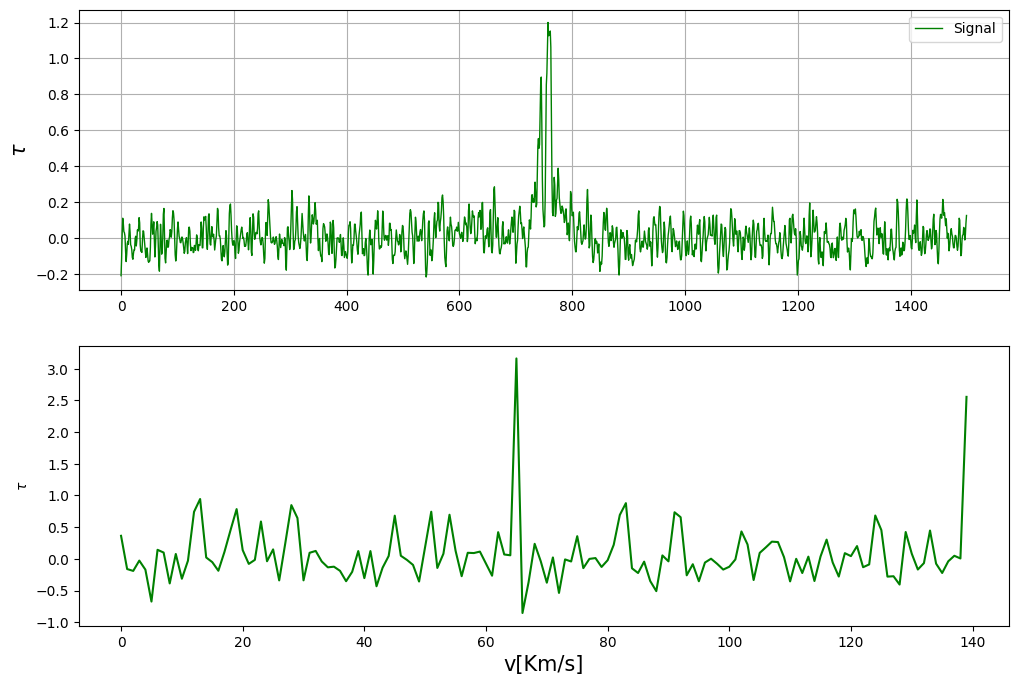

In [20]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(data1[:,1,2], linestyle='-', linewidth=1, color='g', label='Signal')
ax1.set_ylabel(r'$\tau$', fontsize=15)
ax1.grid(True)

# Add legend
ax1.legend()

ax2.plot(data2[:,0,0], color = 'g', label ='Smoothed')
ax2.set_xlabel('v[Km/s]', fontsize=15)
ax2.set_ylabel(r'$\tau$')

plt.show()
